# Geo Embeddings

Notebook to apply different embeddings to represent h3 cells

@roman

24 / 3 / 25

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h3
import os
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE

from INEGIpy import MarcoGeoestadistico

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# settings
pd.options.display.max_columns = 120
geo_framework = MarcoGeoestadistico()

# params
HEX_RESOLUTION = 9

---
# Data

## Read

### Inegi


In [3]:
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

,geometry,cvegeo,cve_agee,nom_agee,nom_abrev,pob,pob_fem,pob_mas,viv
0,"MULTIPOLYGON (((-102.29739 22.45527, -102.2955...",01,01,Aguascalientes,Ags.,1425607,728924,696683,386671
1,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152...",02,02,Baja California,BC,3769020,1868431,1900589,1149563
2,"MULTIPOLYGON (((-109.89451 22.87476, -109.8946...",03,03,Baja California Sur,BCS,798447,392568,405879,240660
3,"MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...",04,04,Campeche,Camp.,928363,471424,456939,260824
4,"MULTIPOLYGON (((-102.31549 29.88000, -102.3150...",05,05,Coahuila de Zaragoza,Coah.,3146771,1583102,1563669,901249


### Hexagons

In [4]:
# hex_id to lat/lon
def hex_to_lat_lon(hex_id):
    lat, lon = h3.h3_to_geo(hex_id)
    return lat, lon

# vectorize function
v_hex_to_lat_lon = np.vectorize(hex_to_lat_lon)

In [5]:
# read hex
gdf_terrain_prices = pd.read_parquet("../../data/misc/terrain_prices.parquet")

# to lat/lon
gdf_terrain_prices["latitude"], gdf_terrain_prices["longitude"] = v_hex_to_lat_lon(gdf_terrain_prices["hex_id"])

# to geodataframe
gdf_terrain_prices = gpd.GeoDataFrame(
    gdf_terrain_prices, 
    geometry=gpd.points_from_xy(gdf_terrain_prices["longitude"], gdf_terrain_prices["latitude"]),
    crs="EPSG:4326"
)

# look
print(gdf_terrain_prices.shape)
gdf_terrain_prices.head()

(261712, 7)


,hex_id,mean_log_valor_fisico_terreno_m2,std_log_valor_fisico_terreno_m2,city_cluster,latitude,longitude,geometry
0,89450984803ffff,6.616558,0.382850,0,20.920002,-89.554488,POINT (-89.55449 20.92000)
1,89450984807ffff,6.627822,0.372650,0,20.922102,-89.557015,POINT (-89.55702 20.92210)
2,8945098480bffff,6.585862,0.349393,0,20.921128,-89.551302,POINT (-89.55130 20.92113)
3,8945098480fffff,6.616438,0.380885,0,20.923228,-89.553829,POINT (-89.55383 20.92323)
4,89450984813ffff,6.624113,0.377989,0,20.916777,-89.555146,POINT (-89.55515 20.91678)


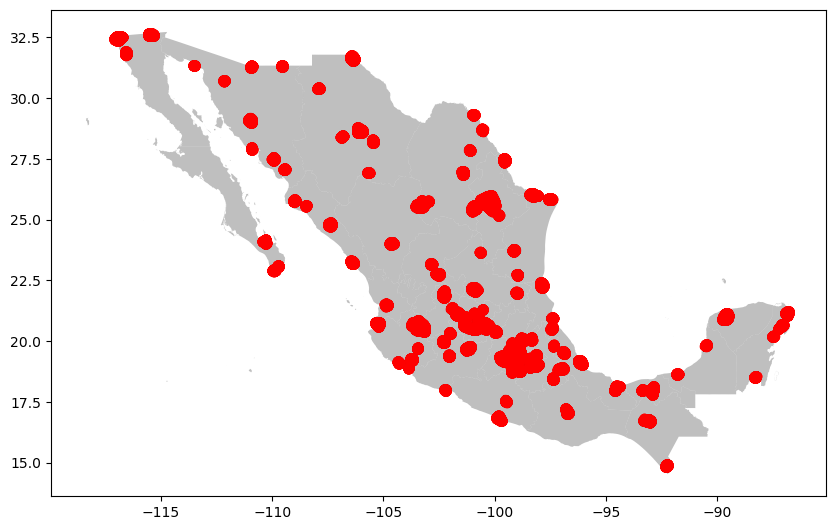

In [6]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot mexico but without boundries
gdf_mex_states.plot(ax=ax, color="gray", alpha=0.5)

# add hexagons
gdf_terrain_prices.plot(ax=ax, color="red", alpha=0.5)

# show
plt.show()

### Cities

In [7]:
# read cities
gdf_cities = gpd.read_parquet("../../data/misc/cities.parquet")

# crs to 4326
gdf_cities = gdf_cities.to_crs(epsg=4326)

# look
print(gdf_cities.shape)
gdf_cities.head()

(114, 3)


,geometry,cluster,total_properties
0,"POLYGON ((-89.76357 20.87249, -89.76472 20.872...",0,49294
1,"POLYGON ((-106.03177 28.56706, -106.03275 28.5...",1,41078
2,"POLYGON ((-106.36144 31.51678, -106.36259 31.5...",2,49914
3,"POLYGON ((-90.53583 19.79132, -90.53673 19.791...",3,4945
4,"POLYGON ((-100.08829 25.34193, -100.08904 25.3...",4,224732


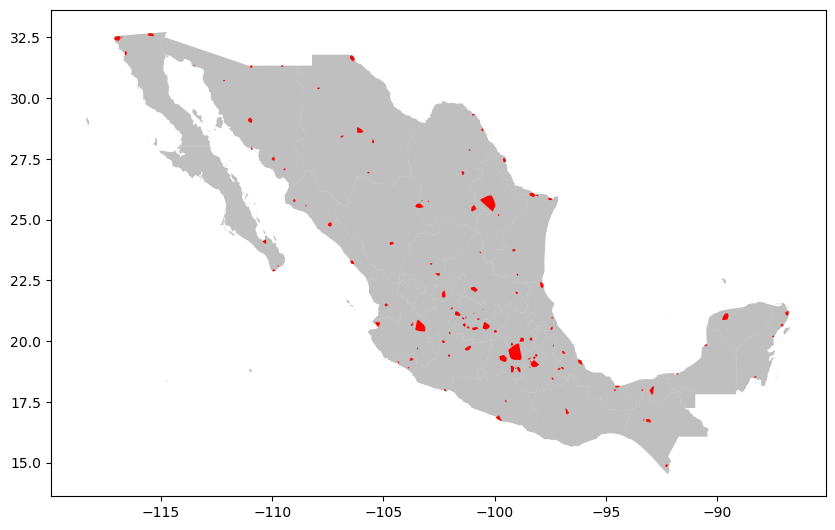

In [8]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot mexico but without boundries
gdf_mex_states.plot(ax=ax, color="gray", alpha=0.5)

# add hexagons
gdf_cities.plot(ax=ax, color="red")

# show
plt.show()

## Wrangle

In [9]:
# spatial join between terrains and cities
gdf_terrain_prices = (
    gdf_terrain_prices
    .sjoin(
        gdf_cities, 
        how="left", 
        predicate="intersects"
    )
    .drop(columns="index_right")
)

# look
print(gdf_terrain_prices.shape)
gdf_terrain_prices.head()

(261712, 9)


,hex_id,mean_log_valor_fisico_terreno_m2,std_log_valor_fisico_terreno_m2,city_cluster,latitude,longitude,geometry,cluster,total_properties
0,89450984803ffff,6.616558,0.382850,0,20.920002,-89.554488,POINT (-89.55449 20.92000),0.0,49294.0
1,89450984807ffff,6.627822,0.372650,0,20.922102,-89.557015,POINT (-89.55702 20.92210),0.0,49294.0
2,8945098480bffff,6.585862,0.349393,0,20.921128,-89.551302,POINT (-89.55130 20.92113),0.0,49294.0
3,8945098480fffff,6.616438,0.380885,0,20.923228,-89.553829,POINT (-89.55383 20.92323),0.0,49294.0
4,89450984813ffff,6.624113,0.377989,0,20.916777,-89.555146,POINT (-89.55515 20.91678),0.0,49294.0


In [10]:
# explore centers on cluster 19
(
    gdf_terrain_prices
    .query("cluster == 19")
    .explore('mean_log_valor_fisico_terreno_m2', tiles='cartodbpositron')
)

---
# Graph2Vec

## S1: Get krings for each hex

In [18]:
# function to get neighbors at ring of size K
def get_neighbors(hex_id, K):
    return list(h3.hex_ring(hex_id, K))

# get neighbors and explode into a DataFrame
df_hex_neighbors = (
    gdf_terrain_prices[["hex_id"]]
    .sample(1000)
    .assign(neighbors=lambda df: df["hex_id"].apply(get_neighbors, K=1))
    .explode("neighbors")
    .rename(columns={"hex_id": "hex_center_id", "neighbors": "hex_neighbor_id"})
    .reset_index(drop=True)
    .set_index(["hex_center_id"])
)

# look
df_hex_neighbors

,hex_neighbor_id
hex_center_id,
89499584b83ffff,89499584b93ffff
89499584b83ffff,89499584b8fffff
89499584b83ffff,89499584b9bffff
89499584b83ffff,89499584b8bffff
89499584b83ffff,89499584b97ffff
...,...
8948364410bffff,89483644157ffff
8948364410bffff,89483644103ffff
8948364410bffff,89483644173ffff


In [19]:
np.isclose(df_hex_neighbors.shape[0] / 6, gdf_terrain_prices.shape[0])

False

In [20]:
# unnique hex_center_id
df_hex_neighbors.index.nunique()

1000

## S2: Create Graph

In [21]:
# edges
edges = [
    (center, neighbor)
    for center, neighbor in tqdm(df_hex_neighbors.itertuples())
]

# look edges
edges[:5]

6000it [00:00, 403498.92it/s]


[('89499584b83ffff', '89499584b93ffff'),
 ('89499584b83ffff', '89499584b8fffff'),
 ('89499584b83ffff', '89499584b9bffff'),
 ('89499584b83ffff', '89499584b8bffff'),
 ('89499584b83ffff', '89499584b97ffff')]

In [22]:
# create graph
G = nx.Graph()
G.add_edges_from(edges)

# Check the graph structure
print(f"Number of nodes: {G.number_of_nodes()}, Number of edges: {G.number_of_edges()}")

Number of nodes: 6918, Number of edges: 5986


Some Hex IDs in the Neighbor Column Don’t Exist in the Main Column

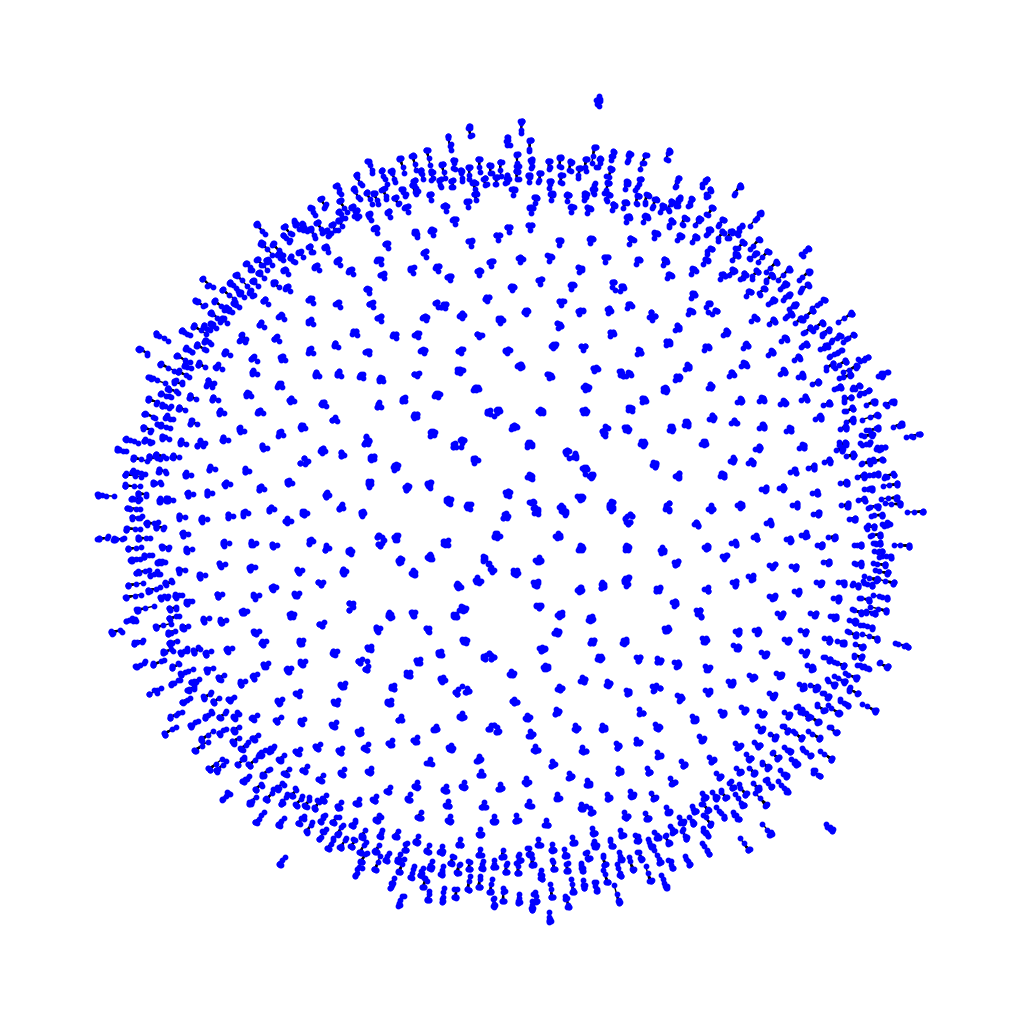

In [23]:
# look at the graph
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=10, node_color="blue", with_labels=False)
plt.show()

## S3: Train Graph2Vec

In [24]:
# Define Node2Vec model
node2vec = Node2Vec(G, dimensions=16, walk_length=10, num_walks=10, workers=4)

# Fit model
model = node2vec.fit(window=5, min_count=1, batch_words=4)

Computing transition probabilities:   0%|          | 0/6918 [00:00<?, ?it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


In [27]:
# Get embedding for one case
model.wv["89499584b83ffff"]

array([ 1.3908027 , -1.2999177 ,  0.77011174,  1.6633098 ,  2.0318096 ,
        3.427877  , -1.5415726 , -1.5701607 , -0.7337417 ,  1.0302182 ,
       -0.41957378, -0.10034681,  2.0529416 ,  0.46533588, -1.5106395 ,
        2.1928604 ], dtype=float32)

In [28]:
# Get embeddings
df_hex_embeddings = pd.DataFrame({hex_id: model.wv[hex_id] for hex_id in G.nodes}).T

# rename columns
df_hex_embeddings.columns = [f"hex_embedding_{i+1}" for i in range(df_hex_embeddings.shape[1])]

df_hex_embeddings

,hex_embedding_1,hex_embedding_2,hex_embedding_3,hex_embedding_4,hex_embedding_5,hex_embedding_6,hex_embedding_7,hex_embedding_8,hex_embedding_9,hex_embedding_10,hex_embedding_11,hex_embedding_12,hex_embedding_13,hex_embedding_14,hex_embedding_15,hex_embedding_16
89499584b83ffff,1.390803,-1.299918,0.770112,1.663310,2.031810,3.427877,-1.541573,-1.570161,-0.733742,1.030218,-0.419574,-0.100347,2.052942,0.465336,-1.510640,2.192860
89499584b93ffff,0.861973,-0.701784,0.554304,1.008414,1.222533,2.152528,-1.006277,-1.012827,-0.394847,0.697307,-0.218951,0.109881,1.263518,0.239110,-0.974677,1.235877
89499584b8fffff,0.923712,-0.744972,0.481126,0.977368,1.279942,2.196934,-1.076211,-1.074903,-0.346013,0.644342,-0.185153,0.017588,1.291550,0.299351,-1.027023,1.325764
89499584b9bffff,0.900948,-0.691675,0.553179,1.026309,1.303291,2.213917,-1.064925,-1.019010,-0.366628,0.675924,-0.141941,0.066333,1.340881,0.280975,-1.017847,1.387752
89499584b8bffff,0.886754,-0.692440,0.491567,1.010230,1.148651,2.080952,-0.990259,-0.961284,-0.434354,0.650689,-0.185541,0.030106,1.330301,0.288700,-0.963585,1.266434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89483644157ffff,0.445630,-1.383350,0.115458,1.344773,1.528994,0.714808,-0.774088,0.507089,-0.331544,0.116428,0.862590,0.463551,1.643441,0.586888,-0.142978,1.790471
89483644103ffff,0.370206,-1.378029,0.140315,1.281860,1.467389,0.737916,-0.816481,0.463103,-0.276521,0.155877,0.863619,0.505832,1.623932,0.609468,-0.144547,1.789513
89483644173ffff,0.389784,-1.366579,0.175233,1.356387,1.581387,0.708249,-0.853655,0.440067,-0.267319,0.123751,0.887737,0.455464,1.636443,0.707435,-0.135284,1.917876
8948364411bffff,0.370068,-1.338618,0.142818,1.402886,1.611880,0.733571,-0.895825,0.474375,-0.350604,0.121982,0.874734,0.495680,1.722808,0.633741,-0.117595,1.901498


## S4: Performance

### Distance

In [29]:
# look pair distance using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# get cosine similarity
df_distance = pd.DataFrame(
    cosine_similarity(df_hex_embeddings),
    index=df_hex_embeddings.index,
    columns=df_hex_embeddings.index
    )

# look
df_distance

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,89499584b83ffff,89499584b93ffff,89499584b8fffff,89499584b9bffff,89499584b8bffff,89499584b97ffff,89499584b87ffff,89483673193ffff,89483673197ffff,8948367352bffff,8948367352fffff,8948367319bffff,89483673567ffff,89483673183ffff,89481478937ffff,89481478927ffff,894814614cbffff,89481478933ffff,894814789afffff,894814614dbffff,89481478923ffff,89484a485a7ffff,89484a485afffff,89484a485b7ffff,89484a4aadbffff,89484a4ae6bffff,89484a4aad3ffff,89484a485a3ffff,896d34da00fffff,896d34da00bffff,896d34da007ffff,896d34da077ffff,896d34da03bffff,896d34da003ffff,896d34da073ffff,8949b36668fffff,8949b366687ffff,8949b366683ffff,8949b3666bbffff,8949b366617ffff,8949b36668bffff,8949b366613ffff,8949a8c8a03ffff,8949a8c8a1bffff,8949a8c8a13ffff,8949a8c8a0fffff,8949a8c8a0bffff,8949a8c8a07ffff,8949a8c8a17ffff,896d32b9e83ffff,896d32b9e97ffff,896d32b9e8fffff,896d32b9e9bffff,896d32b9e93ffff,896d32b9e87ffff,896d32b9e8bffff,896d20c5babffff,896d20c5bafffff,896d20c5ba3ffff,896d20c5b07ffff,...,8949953a307ffff,8949953a30bffff,8949953a31bffff,8949953a317ffff,8929a4d5aabffff,8929a4d5aa3ffff,8929a4d5a17ffff,8929a4d5a33ffff,8929a4d5abbffff,8929a4d5aafffff,8929a4d5a07ffff,894574922b3ffff,8945749204fffff,894574922bbffff,894574922a3ffff,8945749204bffff,894574922b7ffff,89457492287ffff,89498e88907ffff,89498e889abffff,89498e8893bffff,89498e88917ffff,89498e88933ffff,89498e8890fffff,89498e88903ffff,8948814700bffff,89488147073ffff,89488147057ffff,89488147003ffff,8948814701bffff,89488147047ffff,8948814700fffff,89480a82bd7ffff,89480a8286fffff,89480a82bc3ffff,89480a82bd3ffff,89480a82b8bffff,89480a82bc7ffff,89480a82b9bffff,8948a2743afffff,8948a2743a7ffff,8948a2743a3ffff,8948a274333ffff,8948a274337ffff,8948a274edbffff,8948a2743abffff,89498644b8fffff,89498644bbbffff,89498644b17ffff,89498644b83ffff,89498644b87ffff,89498644b13ffff,89498644b8bffff,8948364410bffff,8948364410fffff,89483644157ffff,89483644103ffff,89483644173ffff,8948364411bffff,89483644147ffff
89499584b83ffff,1.000000,0.997432,0.997963,0.997644,0.998371,0.997205,0.997342,0.555452,0.547640,0.539381,0.553854,0.538878,0.532321,0.537107,0.370727,0.375304,0.364556,0.355833,0.353711,0.357839,0.355435,0.230347,0.228684,0.231183,0.226744,0.221858,0.234962,0.233558,0.453803,0.463857,0.453559,0.436991,0.448303,0.454617,0.440038,0.502437,0.506840,0.487003,0.512249,0.499710,0.508493,0.502395,0.447579,0.432101,0.436256,0.436987,0.433737,0.435249,0.427581,0.321857,0.315731,0.323167,0.326360,0.322484,0.322932,0.311962,0.670368,0.660034,0.660687,0.661896,...,0.494093,0.518491,0.505383,0.514130,0.609223,0.566707,0.568184,0.593706,0.590008,0.582816,0.584929,0.358820,0.348354,0.334100,0.340231,0.335680,0.339295,0.343230,0.411815,0.406302,0.404632,0.404165,0.415050,0.406069,0.407969,0.613657,0.614243,0.597642,0.613786,0.609164,0.614478,0.611205,0.564029,0.550731,0.570666,0.561837,0.562179,0.565809,0.561923,0.124792,0.128384,0.119990,0.122118,0.117194,0.115624,0.122271,0.356915,0.330738,0.322777,0.335893,0.326755,0.334488,0.339951,0.753292,0.748877,0.743706,0.747518,0.746259,0.746901,0.751035
89499584b93ffff,0.997432,1.000000,0.998693,0.999053,0.998888,0.999206,0.999400,0.549740,0.541307,0.533687,0.546976,0.532078,0.526109,0.531582,0.363498,0.368275,0.356475,0.348909,0.346063,0.349962,0.347030,0.197253,0.196645,0.199694,0.195080,0.189968,0.203032,0.201106,0.444702,0.455809,0.443173,0.426977,0.438352,0.445693,0.430241,0.480995,0.485847,0.465559,0.490781,0.478794,0.487159,0.481474,0.427754,0.411989,0.416957,0.416689,0.414354,0.414679,0.407582,0.322276,0.316050,0.323648,0.326493,0.323146,0.323176,0.312114,0.668464,0.655061,0.657655,0.658467,...,0.502034,0.525172,0.512729,0.521910,0.597016,0.551998,0.553537,0.580669,0.575019,0.569722,0.570994,0.379895,0.368015,0.354247,0.359039,0.356201,0.358338,0.363141,0.399744,0.394208,0.391801,0.392309,0.403044,0.394053,0.395876,0.624270,0.626914,0.609275,0.625999,0.621500,0.627248,0.624076,0.555803,0.540664,0.561055,0.551388,0.551548,0.556256,0.552723,0.123901,0.127338,0.119311,0.120057,0.115619,0.114461,0.120270,0

In [35]:
# get top 7 neighbors of 8949a8c9143ffff
df_distance.loc["89499584b83ffff"].sort_values(ascending=False).head(8)

89499584b83ffff    1.000000
89499584b8bffff    0.998371
89499584b8fffff    0.997963
89499584b9bffff    0.997644
89499584b93ffff    0.997432
89499584b87ffff    0.997342
89499584b97ffff    0.997205
8949b542c97ffff    0.824916
Name: 89499584b83ffff, dtype: float32

<Axes: >

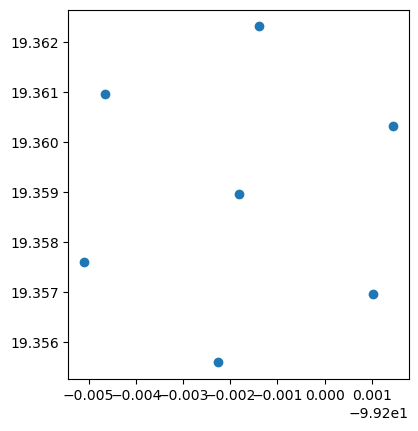

In [34]:
# plot the hexagons
list_similar_hexagons = df_distance.loc["89499584b83ffff"].sort_values(ascending=False).head(7).index

# plot
(
    gdf_terrain_prices
    .query("hex_id in @list_similar_hexagons")
    .plot()
)

### TSNE

In [36]:
# join embeddings to df_terrain_prices
gdf_terrain_prices_v2 = gdf_terrain_prices.merge(
    df_hex_embeddings.reset_index().rename(columns={"index": "hex_id"}),
    how="inner",
    on="hex_id"
)

# look
print(gdf_terrain_prices_v2.shape)
gdf_terrain_prices_v2.head()

(6789, 25)


,hex_id,mean_log_valor_fisico_terreno_m2,std_log_valor_fisico_terreno_m2,city_cluster,latitude,longitude,geometry,cluster,total_properties,hex_embedding_1,hex_embedding_2,hex_embedding_3,hex_embedding_4,hex_embedding_5,hex_embedding_6,hex_embedding_7,hex_embedding_8,hex_embedding_9,hex_embedding_10,hex_embedding_11,hex_embedding_12,hex_embedding_13,hex_embedding_14,hex_embedding_15,hex_embedding_16
0,89450984843ffff,6.642451,0.293660,0,20.920153,-89.545589,POINT (-89.54559 20.92015),0.0,49294.0,0.337699,-0.642375,1.056047,1.413593,0.861511,-0.039699,-0.726341,-0.588955,1.114121,1.052301,0.843717,1.572834,0.895357,-1.597467,-0.185171,1.307773
1,89450984847ffff,6.579522,0.340083,0,20.922253,-89.548116,POINT (-89.54812 20.92225),0.0,49294.0,0.297998,-0.704326,1.007420,1.340621,0.930126,-0.050456,-0.760965,-0.552050,1.121288,0.990535,0.798024,1.515588,0.850470,-1.453794,-0.167841,1.148575
2,8945098484bffff,6.612955,0.255725,0,20.921278,-89.542403,POINT (-89.54240 20.92128),0.0,49294.0,0.297091,-0.626114,1.151713,1.424855,0.941841,0.013973,-0.722529,-0.512487,1.174402,1.041234,0.808451,1.511420,0.856703,-1.485839,-0.194669,1.279397
3,8945098484fffff,6.570216,0.291340,0,20.923378,-89.544930,POINT (-89.54493 20.92338),0.0,49294.0,0.454232,-1.019280,1.778172,2.373180,1.675223,0.001420,-1.168719,-0.992661,1.679845,1.634115,1.244120,2.582965,1.395711,-2.684505,-0.241793,2.050059
4,8945098487bffff,6.640740,0.346729,0,20.925478,-89.547458,POINT (-89.54746 20.92548),0.0,49294.0,0.266868,-0.594901,1.115962,1.455130,0.940370,0.001512,-0.751863,-0.569174,1.172624,0.963211,0.786090,1.557815,0.924134,-1.599837,-0.146488,1.230409


In [37]:
# apply tsne to embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(df_hex_embeddings.filter(like="hex_embedding"))

/Users/ravj/opt/anaconda3/envs/mds-research-stay/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


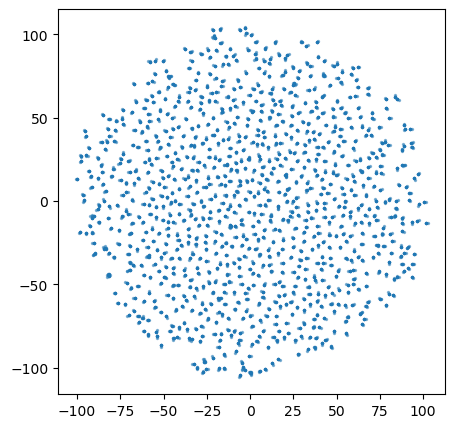

In [38]:
# plot
plt.figure(figsize=(5, 5))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, s=2)
plt.show()

---
# Save

In [ ]:
# save model
model.save("../../models/hex2vec.model")

**Load full model**
model = Word2Vec.load("node2vec_model.model")


**Load just the word vectors**

from gensim.models import KeyedVectors

model_wv = KeyedVectors.load_word2vec_format("hex_embeddings.bin", binary=True)

**Get the embedding for a hex ID**

hex_id = "8928308280fffff"  # Example hex ID

embedding = model.wv[hex_id]

print(embedding)



---
# Sandbox

In [ ]:
gdf_terrain_prices

In [ ]:
# duplicated in gdf_terrain_prices hex_id
gdf_terrain_prices['hex_id'].duplicated().sum()